In [59]:
import time
from scipy.stats import median_absolute_deviation
import scipy.stats
import numpy as np
import pandas as pd
import sqlite3
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from functools import partial, reduce
import plotnine as gg


In [60]:
path = '/Users/habbasi/Desktop/TA/code/cr_median.csv'
metadata_dfpath = '/Users/habbasi/Desktop/TA/input/metadata_TA.csv'
meta2path = '/Users/habbasi/Desktop/TA/input/metadata_TA_2.csv'


## loading data

In [61]:
df = pd.read_csv(path)
metadata_df = pd.read_csv(metadata_dfpath)
meta2 = pd.read_csv(meta2path)
df.shape

metadata = (df.drop_duplicates(subset=['Var1', 'Metadata_moa.x', 'Metadata_Plate_Map_Name.x'])
            .filter(['Var1', 'Metadata_moa.x', 'Metadata_Plate_Map_Name.x'], axis=1)
            .rename(columns={'Var1': 'Metadata_broad_sample',
                            "Metadata_moa.x": "Metadata_moa",
                            "Metadata_Plate_Map_Name.x": "Metadata_Plate_Map_Name"})
           )
metadata.to_csv('/Users/habbasi/Desktop/meta.csv')


df.head()

,Var1,Var2,value,Metadata_moa.x,Metadata_Plate_Map_Name.x,Metadata_moa.y,Metadata_Plate_Map_Name.y
0,BRDN0000464846,BRDN0000464846,1.000000,Transcription Factors,TAORF_REFERENCE_SET,Transcription Factors,TAORF_REFERENCE_SET
1,BRDN0000464847,BRDN0000464846,0.986873,Transcription Factors,TAORF_REFERENCE_SET,Transcription Factors,TAORF_REFERENCE_SET
2,BRDN0000464848,BRDN0000464846,0.265101,Chromatin Modifiers,TAORF_REFERENCE_SET,Transcription Factors,TAORF_REFERENCE_SET
3,BRDN0000464849,BRDN0000464846,0.226072,RTK,TAORF_REFERENCE_SET,Transcription Factors,TAORF_REFERENCE_SET
4,BRDN0000464850,BRDN0000464846,0.261821,RTK,TAORF_REFERENCE_SET,Transcription Factors,TAORF_REFERENCE_SET


## Converting long to wide matrix followed by normalization step and data precprocessing for enrichment score calculation

In [62]:
test = df.pivot(index='Var1', columns='Var2', values='value')
test = test.drop(index=test.index[[0]], columns=test.columns[[0]])      

def normalize_matrix(df):
    tmp = df.where(np.triu(np.ones(df.shape), k=1).astype(bool)).stack()
    tmp = (df - np.median(tmp))/median_absolute_deviation(tmp)
    tmp = tmp/np.quantile(tmp, 0.999)*0.999
    tmp[tmp > 1] = 1
    tmp[tmp < -1] = -1
    np.fill_diagonal(tmp.values,1)
    return tmp

prf = normalize_matrix(test)
prf


def prepare_sm(prf):
    
    tmp1 = (prf.stack()
        .reset_index()
        .rename(columns={'Var1': 'Var1',
                    'Var2': 'Var2',
                    0: "Value"})
        .query('Var1 < Var2  and Var1 != "DMSO" and Var2 != "DMSO"')
        .merge(metadata, left_on='Var1', right_on = 'Metadata_broad_sample', how='left')
        .merge(metadata, left_on='Var2', right_on = 'Metadata_broad_sample', how='left')
        .dropna()
           )
    tmp1['Metadata_moa_x'] = tmp1['Metadata_moa_x'].str.lower()
    tmp1['Metadata_moa_y'] = tmp1['Metadata_moa_y'].str.lower()
    tmp1['same_moa'] = tmp1.apply(lambda x: "True" if x['Metadata_moa_x'] == x['Metadata_moa_y'] else "False", axis=1)
        

    return tmp1
    
melt = prepare_sm(prf)
melt.shape

(20910, 10)

## Calculation of enrichment_top_connection

In [63]:
from numpy import arange

def enrichment_top_conn(melt):
    
    top_perc = [num for num in arange(0.98, 0.997, 0.002)]
    enrichment_score = []
    for i, p in enumerate(top_perc):
        
        thr = np.quantile(melt.Value, p)
        v11 = (melt.query('Value > @thr  and same_moa == "True"').shape[0])
        v12 = (melt.query('Value > @thr  and same_moa != "True"').shape[0])
        v21 = (melt.query('Value < @thr  and same_moa == "True"').shape[0])
        v22 = (melt.query('Value < @thr  and same_moa != "True"').shape[0])
        
        Vector = np.asarray([[v11, v12], [v21, v22]])
        fishertest = scipy.stats.fisher_exact(Vector, alternative="greater")
        
        result = {"top_perc": p,"odds_ratio": fishertest[0], "Pvalue": fishertest[1]}
        enrichment_score.append(result)
    tmp = pd.DataFrame(enrichment_score)
    tmp['top_perc'] = tmp['top_perc'].apply(lambda x: (1 - x)*100)
    
        
    return tmp
    
score = enrichment_top_conn(melt)
thr = np.quantile(melt.Value, 0.98)
thr

0.6002538533456374

### Plotting

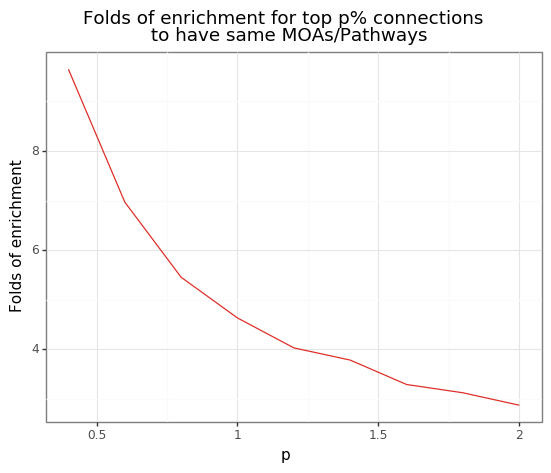

<ggplot: (7020225653)>

In [64]:
(gg.ggplot(data=score,mapping=gg.aes(x='top_perc',y='odds_ratio'))
    + gg.geom_line(color='#de2d26')
    + gg.xlab("p")
    + gg.ylab("Folds of enrichment")
    + gg.labs(title="Folds of enrichment for top p% connections \n to have same MOAs/Pathways")
    + gg.theme_bw()
)